# Streamlining workflows with pipelines
In this section, you will learn about an extremely handy tool, the class in scikit Pipeline learn. It allows us to fit a model including an arbitrary number of transformation steps and apply it to make predictions about new data.

## Loading the Breast Cancer Wisconsin dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

we will assign the 30 features to a NumPy array, X. Using a `LabelEncoder` object, we will transform the class labels from their original string representation ('M' and 'B') into integers.

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
le.transform(['M', 'B'])

array([1, 0])

let's divide the dataset into a separate training dataset (80 percent of the data) and a separate test dataset (20 percent of the data)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

## Combining transformers and estimators in a pipeline

Instead of going through the model fitting and data transformation steps for the training and test datasets separately, we can chain the `StandardScaler`, `PCA`, and `LogisticRegression` objects in a pipeline

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(
    StandardScaler(), 
    PCA(n_components=2), 
    LogisticRegression(random_state=1, solver='lbfgs')
    )
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print("Test Accuracy: %0.3f" %pipe_lr.score(X_test, y_test))

Test Accuracy: 0.942


# Using k-fold cross-validation to assess model performance

A slight improvement over the standard k-fold cross-validation approach is stratifie k-fold cross-validation, which can yield better bias and variance estimates, especially in cases of unequal class proportions. In stratified cross validation, the class label proportions are preserved in each fold to ensure that each fold is representative of the class proportions in the training dataset, which we will illustrate by using the `StratifiedKFold` iterator in scikit-learn.

In [7]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores=[]
for k, (train, val) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[val], y_train[val])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [225 133], Acc: 0.925
Fold:  2, Class dist.: [225 133], Acc: 0.950
Fold:  3, Class dist.: [225 133], Acc: 0.950
Fold:  4, Class dist.: [225 133], Acc: 0.950
Fold:  5, Class dist.: [225 133], Acc: 0.875
Fold:  6, Class dist.: [225 133], Acc: 1.000
Fold:  7, Class dist.: [225 133], Acc: 0.925
Fold:  8, Class dist.: [225 133], Acc: 0.925
Fold:  9, Class dist.: [225 134], Acc: 0.974
Fold: 10, Class dist.: [225 134], Acc: 0.974


In [8]:
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV accuracy: 0.945 +/- 0.033


Although the previous code example was useful to illustrate how k-fold crossvalidation works, scikit-learn also implements a k-fold cross-validation scorer, which allows us to evaluate our model using stratified k-fold cross-validation less verbosely.

In [10]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.925      0.95       0.95       0.95       0.875      1.
 0.925      0.925      0.97435897 0.97435897]

CV accuracy: 0.945 +/- 0.033


# Debugging algorithms with learning and validation curves

## Learning Curves

Diagnosing bias and variance problems.

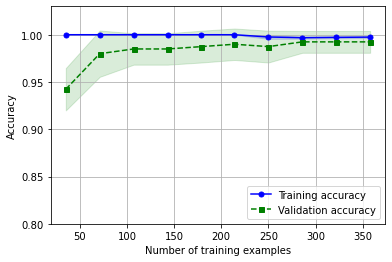

In [12]:
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', max_iter=10000)
)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X = X_train,
    y = y_train, 
    train_sizes=np.linspace(0.1, 1, 10),
    cv=10, 
    n_jobs=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03]) 
plt.show()

## Validation Curves

Addressing overfitting and underfitting.

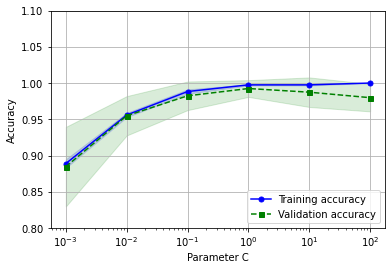

In [19]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(
    estimator=pipe_lr, 
    X = X_train,
    y = y_train,
    param_range = param_range,
    param_name = 'logisticregression__C',
    cv = 10
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.1])
plt.show()

## Grid Search

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1)
)

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
    ]
gs = GridSearchCV(estimator=pipe_svc, 
                param_grid=param_grid,
                scoring='accuracy',
                cv=10,
                refit=True,
                n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9924358974358973
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [21]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test Accuracy: %0.3f' %clf.score(X_test, y_test))

Test Accuracy: 0.959


## Randomized Search

In [33]:
from sklearn.model_selection import RandomizedSearchCV

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_dist = [
    {'svc__C': param_range, 'svc__kernel': ['linear']},
    {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}
    ]
rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_dist,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1,
                        verbose=5) # refit is True by default
rs = rs.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [34]:
print(rs.best_score_)
print(rs.best_params_)
clf = rs.best_estimator_
print('Test Accuracy: %0.3f' %rs.score(X_test, y_test))

0.9924358974358973
{'svc__kernel': 'rbf', 'svc__gamma': 0.01, 'svc__C': 10.0}
Test Accuracy: 0.959


## Nested Cross-validation

In nested cross-validation, we have an outer k-fold cross-validation loop to split the data into training and test folds, and an inner loop is used to select the model using k-fold cross-validation on the training fold. After model selection, the test fold is then used to evaluate the model performance.

In [35]:
gs = GridSearchCV(estimator=pipe_svc,
                param_grid=param_grid,
                scoring='accuracy',
                cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.980 +/- 0.006


In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
param_grid = [{'max_depth': [1,2,3,4,5,6,7,None]}]

gs = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='accuracy', cv=2)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.930 +/- 0.021


# Performance Evaluation Metrics

## Confusion Matrix

In [37]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[105   2]
 [  6  58]]


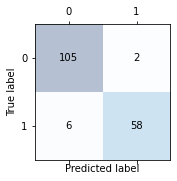

In [38]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Precision, Recall, F1 score

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %0.3f' %precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %0.3f' %recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %0.3f' %f1_score(y_true=y_test, y_pred=y_pred))


Precision: 0.967
Recall: 0.906
F1: 0.935


Remember that the positive class in scikit-learn is the class that is labeled as class 1.

If we want to specify a different positive label, we can construct our own scorer via the make_scorer function, which we can then directly provide as an argument to the scoring parameter in GridSearchCV.

In [41]:
from sklearn.metrics import make_scorer

c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range,'svc__kernel': ['linear']},
                {'svc__C': c_gamma_range, 'svc__gamma': c_gamma_range, 'svc__kernel': ['rbf']}]
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9941176470588236
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## ROC Curve

C:\Users\promar\AppData\Local\Temp\ipykernel_3048\2030359519.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if scipy_version >= Version('1.4.1'):


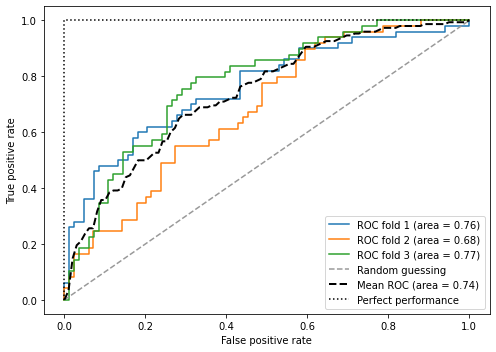

In [45]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()